# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini


In [1]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

## Parameters

In [2]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224

## Initialization

In [4]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [5]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [6]:
def process_video(path, frames_per_video, skip_frames_from_start=0):
    facedet = BlazeFace().to(device)
    facedet.load_weights("../blazeface/blazeface.pth")
    facedet.load_anchors("../blazeface/anchors.npy")
    videoreader = VideoReader(verbose=False)
    video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
    face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)
    vid_faces = face_extractor.process_video(path)
    if(skip_frames_from_start > 0):
        vid_faces = vid_faces[skip_frames_from_start -1:]
    return vid_faces

## Detect faces

In [7]:
#vid_real_faces = process_video('samples/real03.mp4', 100)
real_video_num = 4
vid_fake_faces = process_video('samples/fake.mp4',105, 5)
vid_real_faces_list = []
for i in range(real_video_num):
    file = 'samples/real0' + str(i) +'.mp4'
    print(file)
    vid_real_faces_list.append(process_video(file,100))

samples/real00.mp4
samples/real01.mp4
samples/real02.mp4
samples/real03.mp4


In [8]:
#im_real_face = vid_real_faces[0]['faces'][0]
im_fake_face = vid_fake_faces[0]['faces'][0]
im_real_face_list = []
for vid_real_faces in vid_real_faces_list:
    im_real_face_list.append(vid_real_faces[0]['faces'][0])

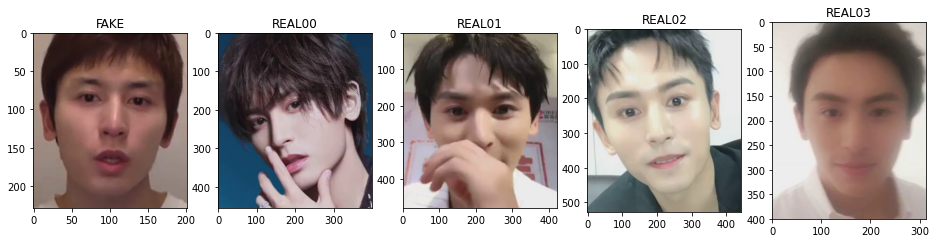

In [9]:
fig,ax = plt.subplots(1,len(im_real_face_list)+1,figsize=(16,10))

ax[0].imshow(im_fake_face)
ax[0].set_title('FAKE')

for i in range(len(im_real_face_list)):
    ax[i+1].imshow(im_real_face_list[i])
    ax[i+1].set_title('REAL0' + str(i));

## Predict scores for each frame

In [10]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
#faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

face_real_t_list = []
for vid_real_faces in vid_real_faces_list:
    face_real_t_list.append(torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] ))

faces_real_pred_list = []
with torch.no_grad():
    #faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()
    for faces_real_t in face_real_t_list:
        faces_real_pred_list.append(net(faces_real_t.to(device)).cpu().numpy().flatten())

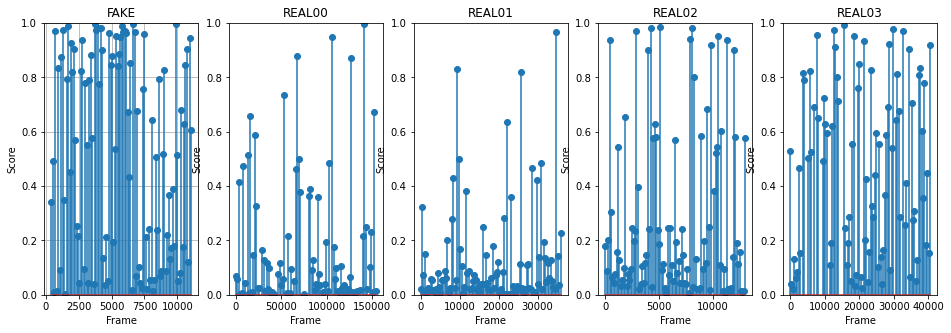

In [15]:
fig,ax = plt.subplots(1,len(im_real_face_list)+1,figsize=(16,5))

ax[0].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[0].set_title('FAKE')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

for i in range(len(faces_real_pred_list)):
    ax[i+1].stem([f['frame_idx'] for f in vid_real_faces_list[i] if len(f['faces'])],expit(faces_real_pred_list[i]),use_line_collection=True)
    ax[i+1].set_title('REAL0' + str(i))
    ax[i+1].set_xlabel('Frame')
    ax[i+1].set_ylabel('Score')
    ax[i+1].set_ylim([0,1])
    #ax[1].set_yticks([0,1],['REAL03','REAL04']);

In [12]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
#print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))
for faces_real_pred in faces_real_pred_list:
    print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))

Average score for FAKE face: 0.5469
Average score for REAL video: 0.0774
Average score for REAL video: 0.0589
Average score for REAL video: 0.1849
Average score for REAL video: 0.4536


In [34]:
from scipy import stats
import numpy as np
confidence = 0.99
all_faces_real_pred = np.array([])
for faces_real_pred in faces_real_pred_list:
    all_faces_real_pred = np.append(all_faces_real_pred, faces_real_pred)
#print(all_faces_real_pred)
stats.t.interval(confidence, len(all_faces_real_pred) -1,
                loc = expit(all_faces_real_pred.mean()),
                scale=stats.sem(all_faces_real_pred))

(-0.15355182875945722, 0.4490968187775542)